# European Airbnb Listing Price Analysis - a Report

## Preliminary Data Loading

In [2]:
options(tidyverse.quiet = TRUE);
suppressPackageStartupMessages(library(tidyverse));
suppressPackageStartupMessages(library(tidymodels));
suppressPackageStartupMessages(library(GGally));
# Cities are, amsterdam, athens, barcelona, berlin, budapest, lisbon, london, paris, rome, vienna, days are weekdays, weekends
url_first <- "https://zenodo.org/record/4446043/files/"
cities <- c("amsterdam", "athens", "barcelona", "berlin", "budapest", "lisbon", "london", "paris", "rome", "vienna");
total_dataset <- tibble()
for (i in 1:10) {
    sub_data <- read_csv(paste(url_first, cities[i], "_weekdays.csv", sep ="")) |>
        mutate(city = cities[i]) |>
        mutate(day = "weekday") |>
        suppressMessages()
    Sys.sleep(0.5) # don't overload their server
    sub_data_end <- read_csv(paste(url_first, cities[i], "_weekends.csv", sep ="")) |>
        mutate(city = cities[i]) |>
        mutate(day = "weekend") |>
        suppressMessages()
    total_dataset <- bind_rows(total_dataset, sub_data, sub_data_end)
    Sys.sleep(0.5) # don't overload their server
}

In [3]:
set.seed(420);

# clean data
airbnb_clean <- total_dataset |>
    select(-1) |> #some incrementing number
# according to https://zenodo.org/record/4446043#.Y9Y9ENJBwUE these columns are dummies:
    select(-room_private, -room_shared) |>
# apparently these are already scaled to [0,100] - drop the duplicate
    select(-attr_index, -rest_index) |>
    mutate(room_type = as_factor(room_type)) |>
    mutate(city = as_factor(city), day = as_factor(day), multi = as_factor(multi), biz = as_factor(biz)) |>
    rename(dist_from_city_centre = dist,
           cost = realSum,
           attraction_index = attr_index_norm,
           restaurant_index = rest_index_norm)

airbnb_clean |>
    select(room_type) |>
    pull() |>
    levels()

glimpse(airbnb_clean)

airbnb_split <- initial_split(airbnb_clean, prop = 0.75, strata = room_type)
airbnb_train <- training(airbnb_split)
airbnb_test <- testing(airbnb_split)

[1] "Private room"    "Entire home/apt" "Shared room"

Rows: 51,707
Columns: 17
$ cost                       <dbl> 194.0337, 344.2458, 264.1014, 433.5294, 485…
$ room_type                  <fct> Private room, Private room, Private room, P…
$ person_capacity            <dbl> 2, 4, 2, 4, 2, 3, 2, 4, 4, 2, 2, 2, 4, 2, 2…
$ host_is_superhost          <lgl> FALSE, FALSE, FALSE, FALSE, TRUE, FALSE, FA…
$ multi                      <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1…
$ biz                        <fct> 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ cleanliness_rating         <dbl> 10, 8, 9, 9, 10, 8, 10, 10, 9, 10, 10, 10, …
$ guest_satisfaction_overall <dbl> 93, 85, 87, 90, 98, 100, 94, 100, 96, 88, 9…
$ bedrooms                   <dbl> 1, 1, 1, 2, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1…
$ dist_from_city_centre      <dbl> 5.0229638, 0.4883893, 5.7483119, 0.3848620,…
$ metro_dist                 <dbl> 2.5393800, 0.2394039, 3.6516213, 0.4398761,…
$ attraction_index           <dbl> 4.166708, 33.421209, 3.985908, 26.119108, 2…
$ restaurant_in

## Introduction

#! should've trimmed this down!!

Europe is the most traveled region in the world (UNWTO, 2023) and there are many countries to explore. In order to have the most enjoyable trip, proper planning and budgeting is required. Airbnb is one of the most popular ways to find accommodation while you travel. Hence, we would like to determine what factors determine the price of an Airbnb listing in ten most popular European cities, how strongly they affect Airbnb listing prices, and build a model that predicts the price given properties about the listing. By performing multivariable linear regression, we will address these predictive statements: What   categorical and numerical factors or predictors exhibit significant correlation with Airbnb room prices? From this, we will use Airbnb determinants that have significant relationship (consider strength and direction) with pricing to predict the cost of an Airbnb room in Europe. The dataset we will use is from a study published in Tourism Management titled, “Determinants of Airbnb prices in European cities: A spatial econometrics approach”. These datasets are separated by city and type of day and contains numerical determinants such as ‘person_capacity’, ‘cleanliness_rating’, ‘bedrooms’ and categorical determinants such as ‘room_type’ and other determinants of Airbnb prices. The variable, ‘realSum’, is the total price of Airbnb listing, which will be predicted using linear regression by analyzing its relationships with Airbnb determinants.

## Methods and Results
- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
  - loads data from the original source on the web 
  - wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
  - performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
  - creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
  - performs the data analysis
  - creates a visualization of the analysis 
  - note: all tables and figure should have a figure/table number and a legend

We first analyze the distribution of the cost for categorical variables, to see what variables would be useful in the analysis.

Warning message:
“attributes are not identical across measure variables; they will be dropped”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 11022 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 38 rows containing missing values (`geom_path()`).”


Rows: 51,707
Columns: 7
$ cost              <dbl> 194.0337, 344.2458, 264.1014, 433.5294, 485.5529, 55…
$ room_type         <fct> Private room, Private room, Private room, Private ro…
$ host_is_superhost <lgl> FALSE, FALSE, FALSE, FALSE, TRUE, FALSE, FALSE, TRUE…
$ multi             <fct> 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1…
$ biz               <fct> 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ city              <fct> amsterdam, amsterdam, amsterdam, amsterdam, amsterda…
$ day               <fct> weekday, weekday, weekday, weekday, weekday, weekday…


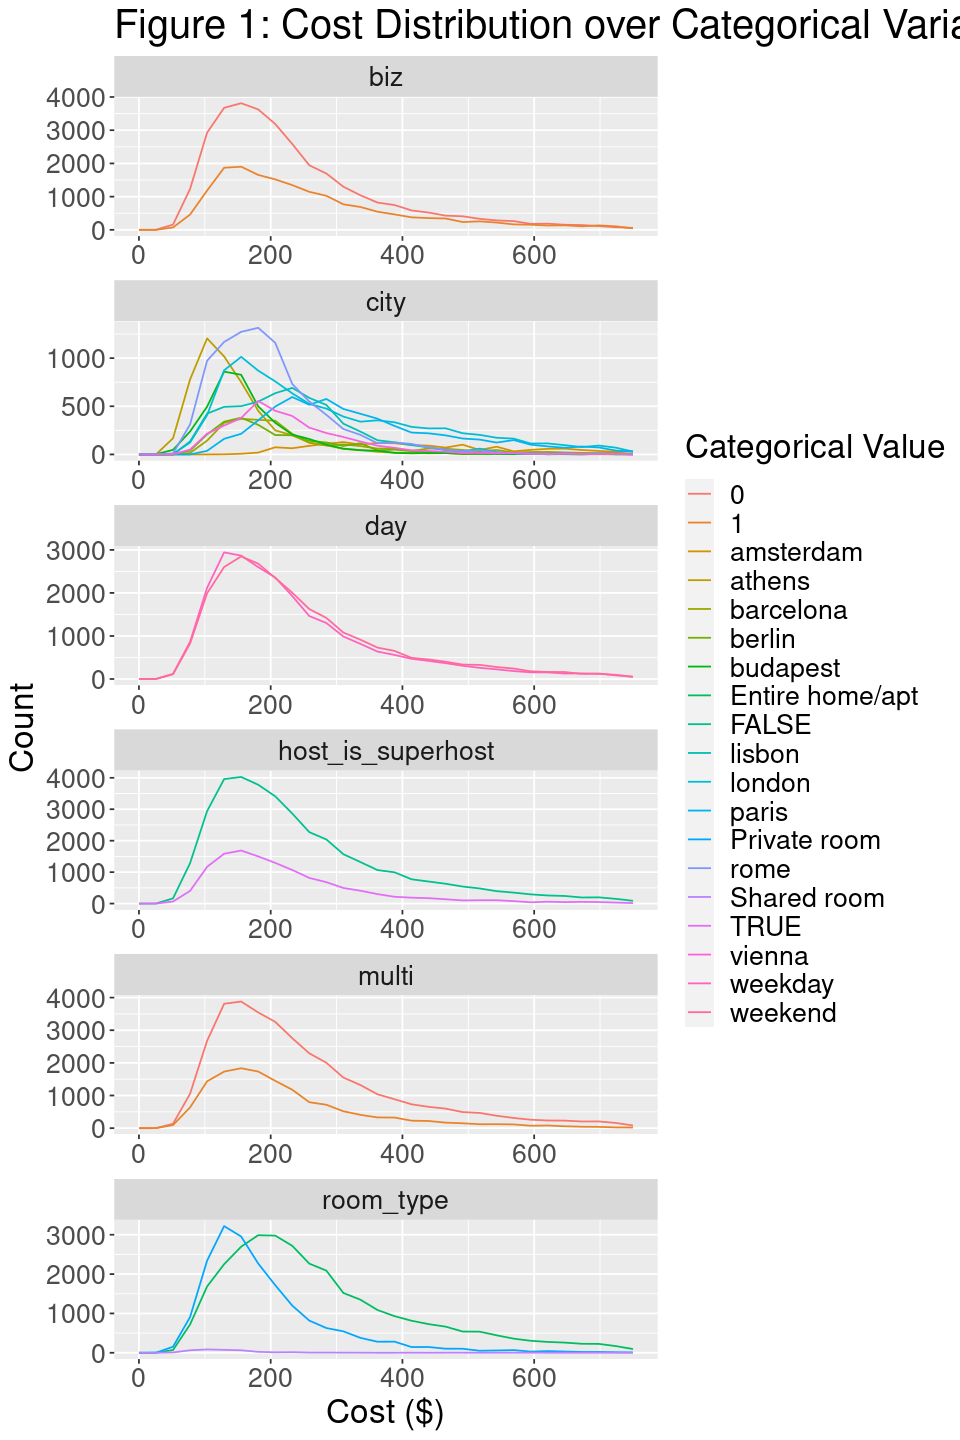

In [33]:
#############################################              #############################################
############################################# TODO CLEANUP #############################################
#############################################              #############################################

options(repr.plot.width = 8, repr.plot.height = 12)

airbnb_categorical <- airbnb_clean |>
    select(-person_capacity, -cleanliness_rating, -guest_satisfaction_overall, -bedrooms, -dist_from_city_centre, -metro_dist, -attraction_index, -restaurant_index, -lng, -lat)

# https://stackoverflow.com/questions/24648729/plot-one-numeric-variable-against-n-numeric-variables-in-n-plots
# can't use ggpairs since we only want against ONE variable
# also ggpairs takes ages + only numeric lol
airbnb_categorical |>
    gather(-cost, key = "variable", value = "value") |>
    ggplot(aes(cost, color = value)) + 
        geom_freqpoly() +
        facet_wrap(~variable, scales = "free", ncol = 1) +
        xlim(0,750) + # want smaller axes
        labs(x = "Cost ($)", y = "Count", color = "Categorical Value", title = "Figure 1: Cost Distribution over Categorical Variables") +
        theme(text = element_text(size = 20))

glimpse(airbnb_categorical);

From this analysis, we see that whether the host is a superhost, the day of the week the data was taken, whether the host is a 'multi-host' or a business does not affect the price, as they each have the same distribution (just with lower counts). However, we notice that the room type and the city clearly has an impact on the price. Thus, we can filter out all categorical variables except the room type and city.

Next, we analyze the numerical variables' distributions versus cost. Note we do not analyze longitude and latitude as that should not have an impact on the cost that is not independent from other included factors, such as the distance from city centre and distance from metro areas.

Warning message:
“Removed 208 rows containing missing values (`geom_point()`).”


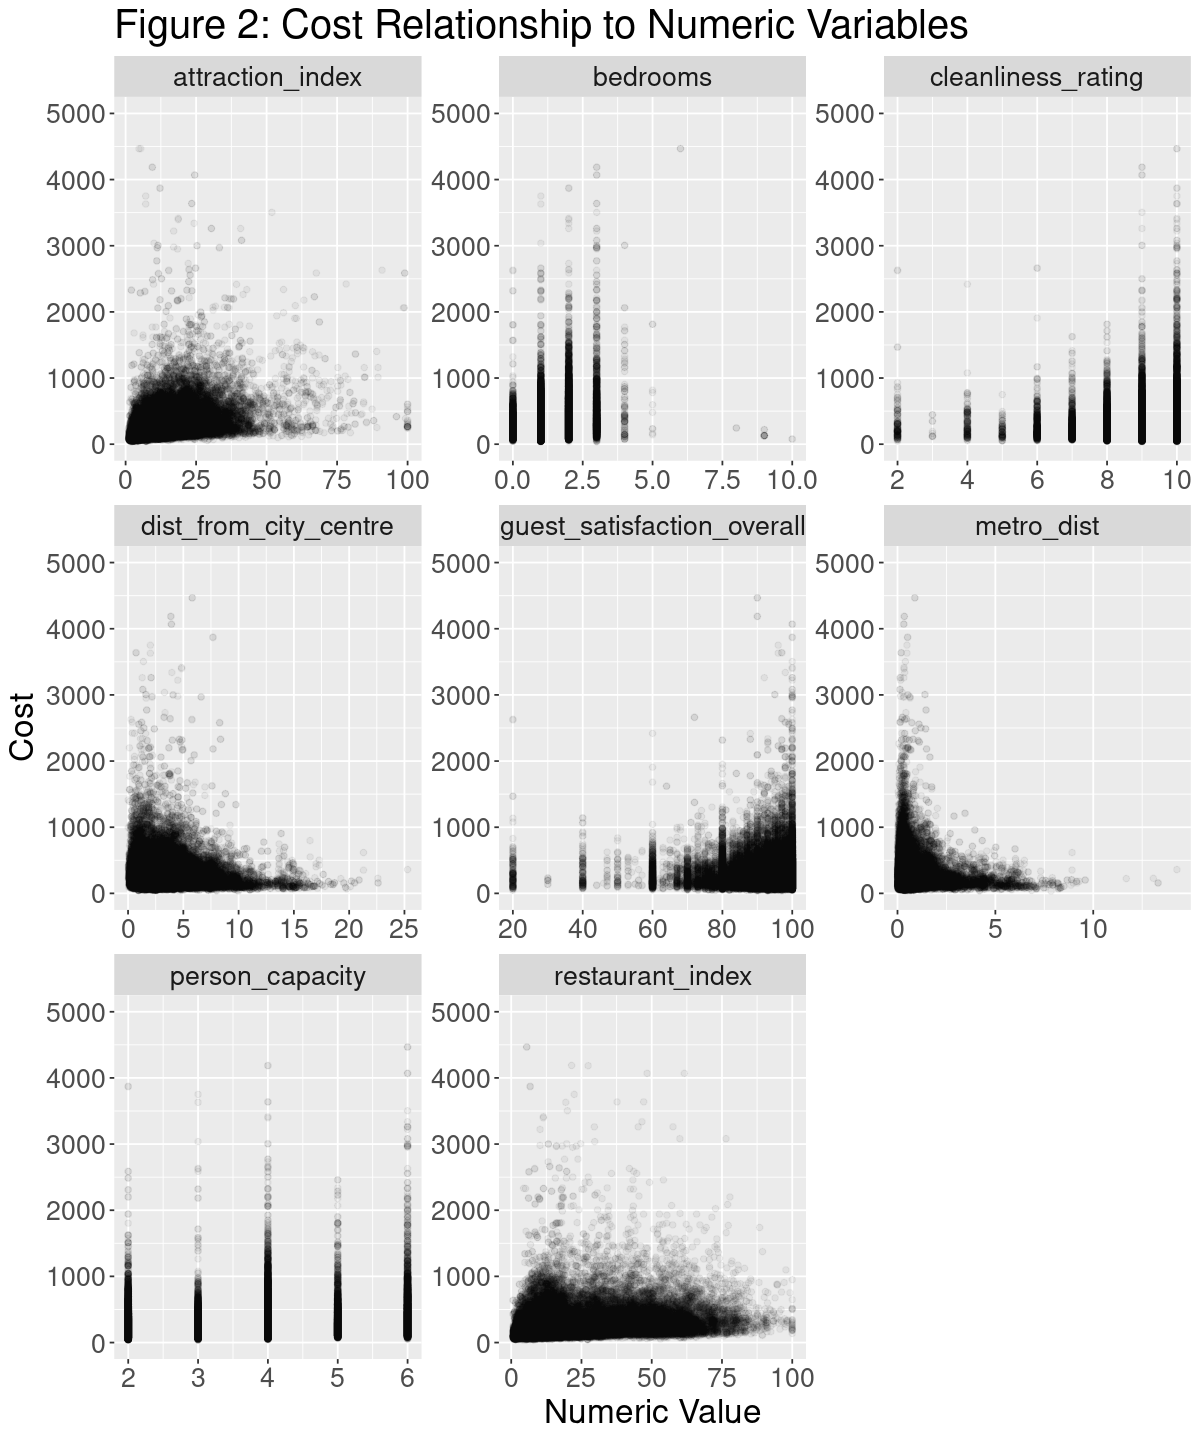

In [47]:
#############################################              #############################################
############################################# TODO CLEANUP #############################################
#############################################              #############################################

options(repr.plot.width = 10, repr.plot.height = 12)

airbnb_numeric <- airbnb_clean |>
    select(cost, person_capacity, cleanliness_rating, guest_satisfaction_overall,
           bedrooms, dist_from_city_centre, metro_dist, attraction_index, restaurant_index)

airbnb_numeric |>
    gather(-cost, key = "variable", value = "value") |>
    ggplot(aes(x=value, y = cost)) + 
        geom_point(alpha = 0.05) +
        facet_wrap(~variable, scales = "free", ncol = 3) +
        ylim(0,5000) + # might remove some outliers but could be problematic
        labs(x = "Numeric Value", y = "Cost", title = "Figure 2: Cost Relationship to Numeric Variables") +
        theme(text = element_text(size = 20))

We see that the capacity of an Airbnb listing likely does not have an impact on the price, but a related variable - the number of available bedrooms, has an impact (a moderately strong positive suspected linear distribution) on the price of the listing. There appears to be a strong positive linear (or strictly increasing polynomial) relationship between cost and the cleanliness rating and overall guest satisfaction. This makes sense, as users would likely want clean rooms and an overall good experience. There is a strong negative linear relationship between cost and the distance from the city center and a strong non-linear, likely polynomial or logarithmic relationship between cost and the distance from metro areas. This would suggest that users prefer to be near the city center/metro areas as it is more accessible. There is a slight positive linear relationship between cost and the restaurant/attraction index, but has a fair amount of variance.

Thus, we fit a linear model that would incorporate these parameters: a one-hot encoded representation of relevant categorical variables - city and room type, a linear relationship between guest satisfaction, distance from city center, restaurant and attraction index, number of bedrooms, cleanliness rating and squared distance from metro areas. However, we notice the presence of outliers, and we next check colinearity between predictors.

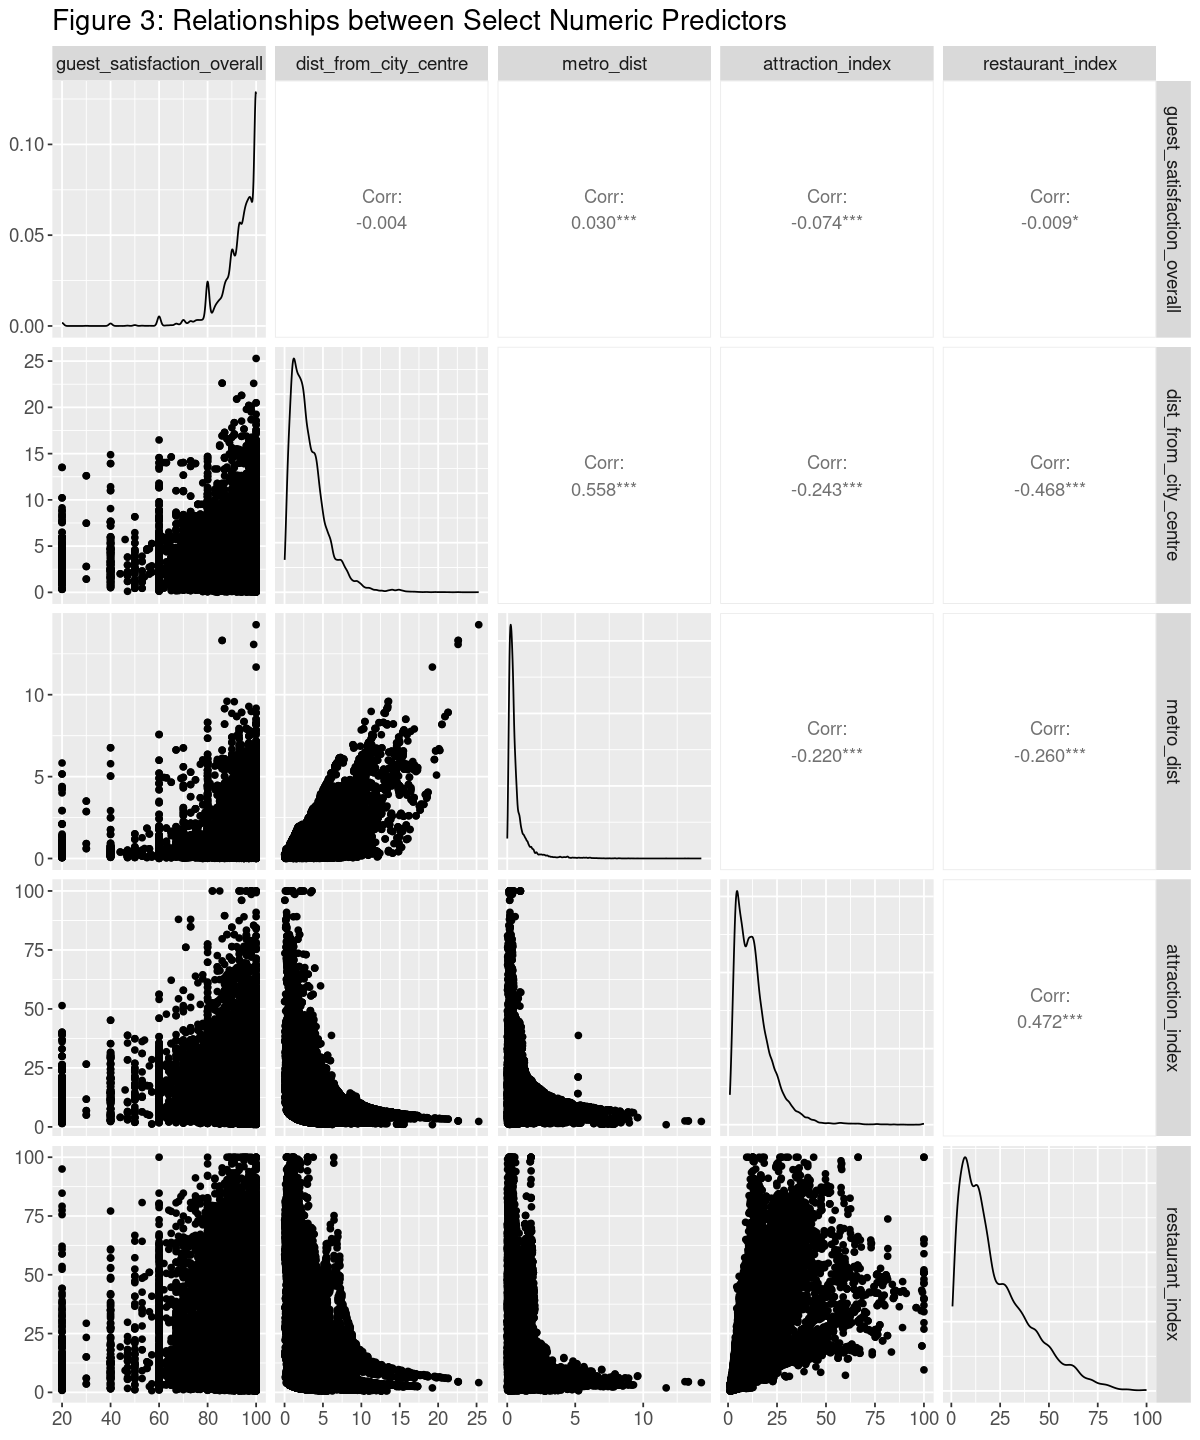

In [49]:
#############################################              #############################################
############################################# TODO CLEANUP #############################################
#############################################              #############################################

options(repr.plot.width = 10, repr.plot.height = 12)

airbnb_sub_numeric <- airbnb_clean |>
    select(guest_satisfaction_overall, dist_from_city_centre, metro_dist, attraction_index, restaurant_index)

ggpairs(airbnb_sub_numeric) +
    labs(title = "Figure 3: Relationships between Select Numeric Predictors") +
    theme(text = element_text(size = 14))

Figure 3 indicates possible relationships between predictors, such as a moderately strong linear erlationship between the distance from city center and distance from metro areas, or a possible linear relationship between the restaurant index and attraction index. This is further supported by the high correlation coefficients between most variables.

<!-- 
I mean technically colinearity is *terrible* and would use something like ridge/lasso regression with something like glmnet...
and also use L1 loss instead of L2 due to outliers

but I don't think we're allowed to do that LOL
-->

In [60]:
#############################################              #############################################
############################################# TODO CLEANUP #############################################
#############################################              #############################################

lm_spec <- linear_reg(mode = "regression", engine = "lm");

lm_recipe <- recipe(cost ~ city + room_type + guest_satisfaction_overall + dist_from_city_centre + metro_dist + attraction_index + restaurant_index, data = airbnb_train) |>
    step_mutate(sqr_metro_dist = (metro_dist**2)) |>
    step_dummy(all_nominal_predictors(), one_hot = TRUE)

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(airbnb_train)

lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_mutate()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
               (Intercept)  guest_satisfaction_overall  
                  -89.5327                      1.0857  
     dist_from_city_centre                  metro_dist  
                    0.2550                    -14.3708  
          attraction_index            restaurant_index  
                    6.9972                     -0.1424  
            sqr_metro_dist              city_amsterdam  
                    0.9747                    345.4911  
               city_athens              city_barcelona  
                  -93.1924                    110.8343  
               city_berlin       

TODO !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Basically some cities super expensive; vienna has no data
entire home/apt is super expensive
restaurant index is small and might not have an effect (at most $14 affect)
distance from city centre small (due to colinearity)


TODO VISUALIZATION!!!!

calculate prediction error:

In [58]:
lm_test_results <- lm_fit |>
    predict(airbnb_test) |>
    bind_cols(airbnb_test) |>
    metrics(truth = cost, estimate = .pred)

lm_test_results

Warning message in predict.lm(object = object$fit, newdata = new_data, type = "response"):
“prediction from a rank-deficient fit may be misleading”


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,316.4008197
rsq,standard,0.1603588
mae,standard,106.4046696


TODO!!!!!

Oh hey look, prediction from rank-deficient fit - colinearity found (wow, we pointed that out!)

use mean absolute error instead of root mean squared error due to outliers: we can predict to about $100? Could do outlier removal

## Discussion
 - summarize what you found
 - discuss whether this is what you expected to find?
 - discuss what impact could such findings have?
 - discuss what future questions could this lead to?

## References

- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.